# Bitcoin Modelling Part 2 - Facebook Prophet
__Niklas Gutheil__<br>
__2022-04-01__

## Table of Contents

* [Introduction](#introduction)
* [Install Prophet](#install)
* [Load in Data](#load)
* [Train-Test Split](#split)
* [Data Preparation for Prophet](#prep_prop)
* [Base Prophet Model](#base_prophet)
  * [Base Model Evaluation](#base_eval)
* [Adding Seasonality](#seasonality)
* [Adding Regressors](#regressors)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

In this notebook I will explore Facebooks Timeseries Forecasting Tool "Prophet". From Facebooks [GitHub:](https://facebook.github.io/prophet/) <br>_"Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well."_<br>

One advantage this model has over SARIMAX is that it can account for multiseasonality, something I discovered to be partially present during the Exploratory Data Analysis phase. There the best result for multi-seasonal decomposition was to account for yearly, quarterly and monthly seasonality. Prophet by default tries to account for yearly, weekly and daily, but custom seasonalities can be added to the model.

Additionally, Prophet also supports multivariate timeseries analysis, so adding regressors will be an easy addition. Overall Prophet is quite user friendly as it has many built in evaluation, cross-validation and plotting features, mnay of which I will explore during this notebook. <br>

The first step is to install Prophet into this Google Colab notebook. If you are running this on a local machine, you will need to install the package into your local environment. 



## Install Prophet <a name="install"></a>

In [1]:
!pip install fbprophet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
import plotly.express as px
from plotly.subplots import make_subplots

Now that all of the required packages are loaded in, I can load the data. I will load in the 1 Day Historical Price Data for Bitcoin as I did for Modelling Part 1.

## Load in Data <a name="load"></a>

In [3]:
from google.colab import files
uploaded = files.upload()

Saving BTCUSD 1D Historical_Data_Modelling.csv to BTCUSD 1D Historical_Data_Modelling (3).csv


In [4]:
import io
bitcoin_df = pd.read_csv(io.BytesIO(uploaded['BTCUSD 1D Historical_Data_Modelling.csv']))
bitcoin_df.head()

Date        Open       Close        High         Low     Volume  \
0  2014-07-21  619.705764  619.601719  619.935799  619.400799   9.087344   
1  2014-07-22  621.136302  621.084288  621.305139  620.849149   7.947902   
2  2014-07-23  619.220937  619.266771  619.425382  619.076406   5.353119   
3  2014-07-24  609.045365  609.008872  609.521875  608.433455  33.808630   
4  2014-07-25  600.420677  600.425868  600.741788  600.079375  14.212595   

        stock   S2F_463MA     Puell  fg_index        OBV       EMA_7  \
0  12713200.0  296.577891  1.283667       0.0  -9.087344  622.811814   
1  12716800.0  296.846171  1.282735       0.0   7.947902  622.379933   
2  12720400.0  297.115114  1.274937       0.0  -5.353119  621.601642   
3  12724000.0  297.384220  1.250308       0.0 -33.808630  618.453450   
4  12727600.0  297.653489  1.229068       0.0 -14.212595  613.946554   

       EMA_14      EMA_21      EMA_28      EMA_50     EMA_100     EMA_250  \
0  623.160314  621.802946  619.088556  605.994310  586.716801  549.612234   
1  622.883511  621.737613  619.226193  606.586074  587.397408  550.195993   
2  622.401279  621.512991  619.228991  607.083356  588.028543  550.760026   
3  620.615624  620.376253  618.524155  607.158866  588.444032  551.235593   
4  617.923657  618.562582  617.275997  606.894827  588.681317  551.637123   

        RSI  
0  0.442006  
1  0.465235  
2  0.437999  
3  0.311621  
4  0.247059

In [5]:
bitcoin_df['Date'] = pd.to_datetime(bitcoin_df['Date'])
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2722 entries, 0 to 2721
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2722 non-null   datetime64[ns]
 1   Open       2722 non-null   float64       
 2   Close      2722 non-null   float64       
 3   High       2722 non-null   float64       
 4   Low        2722 non-null   float64       
 5   Volume     2722 non-null   float64       
 6   stock      2722 non-null   float64       
 7   S2F_463MA  2722 non-null   float64       
 8   Puell      2722 non-null   float64       
 9   fg_index   2722 non-null   float64       
 10  OBV        2722 non-null   float64       
 11  EMA_7      2722 non-null   float64       
 12  EMA_14     2722 non-null   float64       
 13  EMA_21     2722 non-null   float64       
 14  EMA_28     2722 non-null   float64       
 15  EMA_50     2722 non-null   float64       
 16  EMA_100    2722 non-null   float64       


The index has been set and the data was successfully loaded in. Now it is time to split our data into Train and Test. This time I am going to ask Prophet to predict the entire 6 months of test data since this Model is built to farecast much further ahead. Before doing that, I will drop Close, High, Low and stock as I did in the previous modelling notebook since they are too similar to our target variable Open, and stock is simply a straight line.

In [6]:
bitcoin_df.drop(columns = ['Close', 'High', 'Low', 'stock'], inplace = True)

## Train-Test Split <a name="split"></a>

Below is a visual of what the split looks like on Bitcoins Price Chart.

In [7]:
# add lines for each column
fig = px.line(bitcoin_df, x=bitcoin_df.index, y=['Open'],)

# axis labels and title
fig.update_layout(
    yaxis_title="Price in USD", 
    legend_title="", 
    title="Price of Bitcoin 2014-2022", 
    yaxis_tickprefix = '$', 
    yaxis_tickformat = ',.2f'
)

# activate slider
fig.update_yaxes(fixedrange = False, autorange = True) # you can zoom in on the y-axis by dragging the bottom corners 
                                                       
fig.update_xaxes(rangeslider_visible=True)

fig.add_vline(x = 2537)


fig.show()

Now for the split.

In [8]:
train = bitcoin_df[(bitcoin_df['Date'] < '2021-07-01') ]
test = bitcoin_df[(bitcoin_df['Date'] >= '2021-07-01') ]

In [9]:
train.tail(3)

Date          Open     Volume     S2F_463MA     Puell  fg_index  \
2534 2021-06-28  34492.251606  21.448459  33656.058114  0.948925      25.0   
2535 2021-06-29  35558.544231  19.144583  33797.869906  0.976986      25.0   
2536 2021-06-30  35091.281052  12.667995  33939.699374  0.962932      28.0   

            OBV         EMA_7        EMA_14        EMA_21        EMA_28  \
2534  21.448459  33683.831286  34478.515671  35292.171628  36215.257688   
2535  19.144583  34153.787304  34623.200963  35316.851967  36170.319597   
2536 -12.667995  34386.786635  34684.878785  35295.845846  36095.524082   

            EMA_50       EMA_100       EMA_250       RSI  
2534  39246.525833  42566.193715  37987.445831  0.496679  
2535  39102.099540  42427.529589  37968.132759  0.556716  
2536  38944.596994  42282.148501  37945.165842  0.526361

In [10]:
test.head(3)

Date          Open     Volume     S2F_463MA     Puell  fg_index  \
2537 2021-07-01  33716.208585  22.997432  34081.546519  0.924135      28.0   
2538 2021-07-02  33290.346046  17.866111  34223.411342  0.911440      21.0   
2539 2021-07-03  34313.193655  10.300798  34365.293844  0.938310      24.0   

            OBV         EMA_7        EMA_14        EMA_21        EMA_28  \
2537 -22.997432  34217.920349  34555.071146  35151.798177  35931.096317   
2538 -17.866111  33986.280614  34386.576514  34982.667562  35749.045633   
2539  10.300798  34069.072689  34377.359501  34922.193139  35650.314825   

            EMA_50       EMA_100       EMA_250       RSI  
2537  38739.370504  42112.429154  37911.430030  0.440360  
2538  38525.723088  41937.754545  37874.616734  0.416771  
2539  38360.692728  41786.857404  37846.272768  0.492510

The dates match up on either end of the two set sets, which is required. 

## Data Preparation for Prophet <a name = "prep_prop"></a>

Prophet wants the data in a format with two columns, `ds` and `y`. `ds` holds the dates of the timeseries while `y` holds the target variable, in this case 'Open'. I will go ahead and build one dataframe for train and test, as well as build one data frame for the additional variables in train and test.

In [11]:
model_train_df = train[['Date', 'Open']]
model_train_df.rename(columns = {'Date': 'ds', 'Open': 'y'}, inplace = True)
model_train_df.tail(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ds             y
2534 2021-06-28  34492.251606
2535 2021-06-29  35558.544231
2536 2021-06-30  35091.281052

In [12]:
model_test_df = test[['Date', 'Open']]
model_test_df.rename(columns = {'Date': 'ds', 'Open': 'y'}, inplace = True)
model_test_df.head(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ds             y
2537 2021-07-01  33716.208585
2538 2021-07-02  33290.346046
2539 2021-07-03  34313.193655

Now for the additional variables.

In [13]:
model_regressors_train = train[['Volume',	'S2F_463MA',	'Puell',	'fg_index',	'OBV',	'EMA_7',	'EMA_14',	'EMA_21',	'EMA_28'	,'EMA_50',	'EMA_100',	'EMA_250',	'RSI']]
model_regressors_test = test[['Volume',	'S2F_463MA',	'Puell',	'fg_index',	'OBV',	'EMA_7',	'EMA_14',	'EMA_21',	'EMA_28'	,'EMA_50',	'EMA_100',	'EMA_250',	'RSI']]


## Base Prophet Model <a name = "base_prophet"></a>

First I will build a baseline Prophet Model that has only deafult hyperparameter values and just takes in the date and y values.

In [14]:
model = Prophet()
model.fit(model_train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Now I will make a forecast by creating something called a future_dataframe. This dataframe needs to be of the length of the test data and needs to specify what time period your data is in.

In [15]:
future = model.make_future_dataframe(periods = len(model_test_df), freq = 'D')
future.head(3)

ds
0 2014-07-21
1 2014-07-22
2 2014-07-23

Now I will make a prediction and display the values `ds`, `yhat`, `yhat_lower` and `yhat_upper`.

In [16]:
# this cell might take a few seconds to run
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
2717 2021-12-28  64452.258116  58964.391116  70602.039061
2718 2021-12-29  64667.781016  59382.427529  70714.045251
2719 2021-12-30  64888.864468  58705.691826  71393.896676
2720 2021-12-31  65055.139127  59222.567740  71627.032615
2721 2022-01-01  65290.670084  59173.113637  71399.586596

Here we have a few values to look at. `ds` is of course the date of the prediction, `yhat` is the prediction generated and `yhat_lower`/`yhat_upper` represent the lower and upper bounds of that prediction. Let's graph out the prediction.

In [17]:
from fbprophet.plot import plot_plotly
import plotly.graph_objs as go

fig = plot_plotly(model, forecast) # returns a plotly Figure object
fig.add_trace(go.Scatter(x=model_test_df['ds'], y=model_test_df['y'], mode='lines', name="Test"))
fig.update_xaxes(rangeslider_visible=True)

fig.update_layout(
    yaxis_title="Price of BTC", 
    legend_title="", 
    title="Price of Bitcoin from 2014-2022"
)

fig.show()

It appears that the model did alright. The model knew to continue the upward price movment despite the training data ending in a downward trend. The past values must be affecting the future more than in the SARIMAX model.<br>

For this model I will use RMSE (Root mean squared error). To get the RMSE of our model, I can run Prophets built in cross-validation, graph the RMSE and find the mean RMSE for the entire forecast. Let's start with cross-validation.


### Base Model Evaluation <a name = "base_eval"></a>

Breaking down the built-in function, the first argument is our model `model`. Cross-validation is done here on a prediction horizon of 182 days (6 months), starting with 730 days of training data in the first cutoff, and then making predictions every 91 days (3 months). On this roughly 8 year timeseries, that will be 18 total forecast.

In [18]:
# this cell will take about a minute to run
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='91 days', horizon = '182 days')
df_cv.head()


INFO:fbprophet:Making 18 forecasts with cutoffs between 2016-10-05 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/18 [00:00<?, ?it/s]

ds        yhat  yhat_lower  yhat_upper           y     cutoff
0 2016-10-06  596.375297  567.056927  628.010672  613.744583 2016-10-05
1 2016-10-07  598.154266  566.232338  629.555626  617.613872 2016-10-05
2 2016-10-08  599.684229  570.172780  632.045865  620.207431 2016-10-05
3 2016-10-09  601.452519  569.642392  631.247927  618.225312 2016-10-05
4 2016-10-10  603.965807  574.861969  633.658530  618.404497 2016-10-05

Now to get the performance metrics, which I will find the mean for.

In [19]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

df_p = performance_metrics(df_cv).mean().to_frame().T
df_p

horizon               mse          rmse          mae      mape  \
0 100 days 12:00:00  122975463.101817  10728.907763  6117.604139  0.507229   

      mdape  coverage  
0  0.439644  0.174293

/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:526: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:527: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



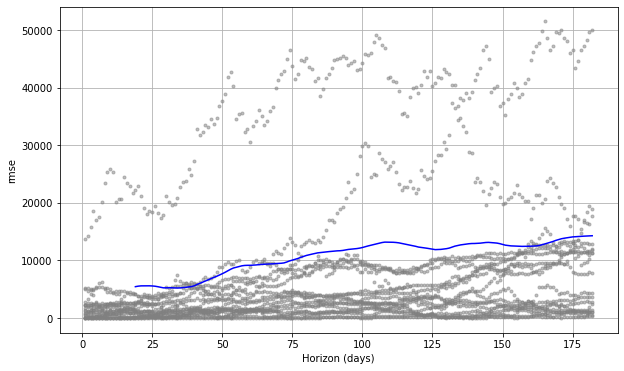

In [20]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

Looking at the output for the performance metrics I can see the average RMSE is 10728. The graph shows that as the forecast goes on, more variance is unaccounted for. <br>

It appears that our baseline accuracy will be RMSE = 20728. I will move on to creating a grid search that utilizes cross-validation and return the best hyperparameters for our data that does not yet include additional regressors.<br>

The following code is based on [this](https://medium.com/analytics-vidhya/time-series-analysis-using-prophet-in-python-part-2-hyperparameter-tuning-and-cross-validation-88e7d831a067) Medium.com article with some revisions, which in turn is based off of [this](https://nbviewer.org/github/ryankarlos/prophet/blob/9e6d9548d1caca27af3367819bab10a65da10392/notebooks/diagnostics.ipynb#Hyperparameter-Optimisation) notebook.<br>

In this code two functions are defined, `create_param_combinations` and `single_cv_run`. The first function takes in a dictionary of our parameters and creates all combinations of the same length and returns a dataframe. The second function takes in the timeseries, a list of metrics that should be stored, and the dictionary of hyperparameters for our model.

In [21]:
def create_param_combinations(**param_dict):
    """ 
    Creates a dataframe of the product of all hyperparameter ranges passed in

    Parameters: 
    param_dict : dictionary
        A dictorinary containing the hyperparameters to be used
    
    Returns: 
    params_df : DataFrame
        A DataFrame containing the product of all hyperparameters
        
    """

    param_iter = itertools.product(*param_dict.values()) 
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict):

    """ 
    Runs a cross-validation given a set of hyperparameters and return the performance metrics given as a list

    Parameters: 
    history_df : DataFrame
        A DataFrame containing the timeseries data
    
    metrics : list
        A list containing the metrics that want to be calculated

    param_dict: dict
        A dictionary containing the hyperparameters for modelling

    
    Returns: DataFrame
        A DataFrame containing the performance metrics calculated from Cross-Validation
        
    """

    m = Prophet(**param_dict)
    m.fit(history_df)
    df_cv = cross_validation(m, initial='1700 days', period='91 days', horizon = '182 days')
    df_p = performance_metrics(df_cv).mean().to_frame().T
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

Next is to define our hyperparameter grid, the metrics we want, as well as creating a loop that will cycle through all hyperparameter combinations, building and validating all models. The results are concatonated into a dataframe where the best resulting model based on RMSE is selected.<br>

The hyperparameters are as follows: 
* __Changepoint_prior_scale:__ It determines the flexibility of the trend, and in particular how much the trend changes at the trend changepoints. If it is too small, the trend will be underfit and variance that should have been modeled with trend changes will instead end up being handled with the noise term. If it is too large, the trend will overfit and in the most extreme case you can end up with the trend capturing yearly seasonality. A range of [0.001, 0.5] is recommended by the facebook, on a log scale.

* __changepoint_range:__ This is the proportion of the history in which the trend is allowed to change. This defaults to 0.8, 80% of the history, meaning the model will not fit any trend changes in the last 20% of the time series. This is fairly conservative, to avoid overfitting to trend changes at the very end of the time series where there isn’t enough runway left to fit it well. I will explore 0.8 and a more aggresive 0.9 value.

* __seasonality_prior_scale:__ This parameter controls the flexibility of the seasonality. Similarly, a large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality. The default is 10., which applies basically no regularization. Facebook recommends a range from 0.01 to 1 in log scale.

* __seasonality_mode:__ Options are ['additive', 'multiplicative']. This determines if the seasonality should be added or multiplied to the trend as it goes no. I will test for both.<br>

In this case I have chosen to start the cross-validation at 1700 days since 8 folds is enough and would otherwise needlesly increase the runtime.

In [22]:
import itertools
# this cell will take a while to run, around 40 minutes on google colab pro+

# Here we specify the ranges of hyperparameters we want to tune
param_grid = {  
                'changepoint_prior_scale': [0.001, 0.05, 0.5],
                'changepoint_range': [0.8, 0.9],
                'seasonality_prior_scale':[0.01, 0.1, 1, 10.0],
                'seasonality_mode': ['multiplicative', 'additive']
              }

# a list of the metrics we want to calculate 
metrics = ['horizon', 'rmse', 'mape', 'params'] 

# a palce to store intermediary results before adding to a dataframe 
results = []

# create combinations of the hyperparameters specified above 
params_df = create_param_combinations(**param_grid)

print(f"Running a Total of {params_df.shape[0]} Models")
# for every combination of hyperparameters, run a cross-validation and append the results to a dataframe
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(model_train_df,  metrics, param_dict)
    results.append(cv_df)
results_df = pd.concat(results).reset_index(drop=True)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Running a Total of 48 Models


INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

In [23]:
# here we select the best parameters based on RMSE
best_param = results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]
rmse = min(results_df['rmse'])
print(f'\n The best param combination is {best_param.values[0][0]} with RMSE {rmse}')

# dispay sorted dataframe after optimal hyperparameters
results_df.sort_values('rmse', ascending = True)


 The best param combination is {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.9, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive'} with RMSE 11787.469033012396


horizon          rmse      mape  \
43 100 days 12:00:00  11787.469033  0.456489   
47 100 days 12:00:00  11791.744011  0.458419   
45 100 days 12:00:00  11837.083062  0.458586   
41 100 days 12:00:00  11870.913576  0.464797   
31 100 days 12:00:00  12938.954873  0.464519   
25 100 days 12:00:00  12954.462117  0.464542   
27 100 days 12:00:00  12958.465582  0.468462   
29 100 days 12:00:00  12960.856502  0.466722   
40 100 days 12:00:00  12963.830809  0.496736   
46 100 days 12:00:00  13460.621191  0.552923   
42 100 days 12:00:00  13606.690733  0.576988   
44 100 days 12:00:00  13699.327305   0.60791   
24 100 days 12:00:00  13891.017251  0.562225   
33 100 days 12:00:00  14990.369441  0.368947   
39 100 days 12:00:00   15008.19989   0.37198   
35 100 days 12:00:00  15008.805906  0.372349   
37 100 days 12:00:00  15015.648439  0.372427   
17 100 days 12:00:00  15089.211993  0.418125   
19 100 days 12:00:00  15089.293919  0.418359   
21 100 days 12:00:00  15098.419286   0.41595   
23 100 days 12:00:00   15113.42862  0.419445   
32 100 days 12:00:00  15321.288624  0.418753   
16 100 days 12:00:00  15344.727105   0.41614   
1  100 days 12:00:00  15383.931945  0.287191   
3  100 days 12:00:00  15385.912478  0.288551   
15 100 days 12:00:00  15398.342189  0.284389   
5  100 days 12:00:00  15399.412167  0.285123   
13 100 days 12:00:00  15406.966981  0.284761   
7  100 days 12:00:00  15414.551825   0.28778   
8  100 days 12:00:00  15440.897836  0.284122   
11 100 days 12:00:00   15447.86632  0.286418   
9  100 days 12:00:00  15448.928083  0.286677   
0  100 days 12:00:00  15481.265664  0.281332   
26 100 days 12:00:00  15527.410441  0.767247   
28 100 days 12:00:00  15530.054349  0.769954   
12 100 days 12:00:00   15642.13412  0.286216   
38 100 days 12:00:00  15648.112424  0.437055   
34 100 days 12:00:00  15648.891121  0.436847   
30 100 days 12:00:00  15649.715589  0.782199   
36 100 days 12:00:00  15651.606592  0.438614   
14 100 days 12:00:00  15663.111408  0.287694   
18 100 days 12:00:00  15670.209179  0.421138   
22 100 days 12:00:00  15670.795847  0.421575   
20 100 days 12:00:00  15675.725101  0.419059   
4  100 days 12:00:00  15690.633587  0.284308   
10 100 days 12:00:00  15698.908364  0.285884   
2  100 days 12:00:00  15701.084852  0.284933   
6  100 days 12:00:00  15710.987319  0.286043   

                                               params  
43  {'changepoint_prior_scale': 0.5, 'changepoint_...  
47  {'changepoint_prior_scale': 0.5, 'changepoint_...  
45  {'changepoint_prior_scale': 0.5, 'changepoint_...  
41  {'changepoint_prior_scale': 0.5, 'changepoint_...  
31  {'changepoint_prior_scale': 0.05, 'changepoint...  
25  {'changepoint_prior_scale': 0.05, 'changepoint...  
27  {'changepoint_prior_scale': 0.05, 'changepoint...  
29  {'changepoint_prior_scale': 0.05, 'changepoint...  
40  {'changepoint_prior_scale': 0.5, 'changepoint_...  
46  {'changepoint_prior_scale': 0.5, 'changepoint_...  
42  {'changepoint_prior_scale': 0.5, 'changepoint_...  
44  {'changepoint_prior_scale': 0.5, 'changepoint_...  
24  {'changepoint_prior_scale': 0.05, 'changepoint...  
33  {'changepoint_prior_scale': 0.5, 'changepoint_...  
39  {'changepoint_prior_scale': 0.5, 'changepoint_...  
35  {'changepoint_prior_scale': 0.5, 'changepoint_...  
37  {'changepoint_prior_scale': 0.5, 'changepoint_...  
17  {'changepoint_prior_scale': 0.05, 'changepoint...  
19  {'changepoint_prior_scale': 0.05, 'changepoint...  
21  {'changepoint_prior_scale': 0.05, 'changepoint...  
23  {'changepoint_prior_scale': 0.05, 'changepoint...  
32  {'changepoint_prior_scale': 0.5, 'changepoint_...  
16  {'changepoint_prior_scale': 0.05, 'changepoint...  
1   {'changepoint_prior_scale': 0.001, 'changepoin...  
3   {'changepoint_prior_scale': 0.001, 'changepoin...  
15  {'changepoint_prior_scale': 0.001, 'changepoin...  
5   {'changepoint_prior_scale': 0.001, 'changepoin...  
13  {'changepoint_prior_scale': 0.001, 'changepoin...  
7   {'changepoint_prior_scale': 0.00

Using the above output for the best hyperparameters, I will build and then predict this model. I can also note that the RMSE for the tuned model is 11787, which is technically higher than our base model. However, our MAPE score is lower so I will go ahead and graph the results to visually inspect the change hyperparameter tuning as made.

In [24]:
# this cell will take a few seconds to run

# create a model with the found hyperparameters
m= Prophet(
    changepoint_prior_scale=0.5,
    changepoint_range=0.8,
    seasonality_prior_scale=0.1,
    seasonality_mode='additive'
)

# fit the model
m.fit(model_train_df)

# make a future dataframe
future = m.make_future_dataframe(periods = 180)
future['cap'] = 60000
future['floor'] = 0

# make a forecast
forecast = m.predict(future)

#plot the forecast compared to the actual values 
fig = plot_plotly(m, forecast) # returns a plotly Figure object
fig.add_trace(go.Scatter(x=model_test_df['ds'], y=model_test_df['y'], mode='lines', name="Test"))
fig.update_xaxes(rangeslider_visible=True)

fig.update_layout(
    yaxis_title="Price of Bitcoin", 
    legend_title="", 
    title="Price of Bitcoin from 2014-2022"
)

fig.show()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


It appearst that our line has actually improved based upon visual inspection. The upper and lower ranges diverge now, but it was able to detect the future rise in prices again. It decided not to weight the downtrend as heavily and thus was able to predict the future upswing better. There are points in the training date where it failed to capture the trend, as seen in early 2020. This was when COVID-19 hit the financial markets around the world, not exactly something a model would be able to predict without additonal information pertaining to COVID numbers etc. 

## Adding Seasonality <a name = 'seasonality'></a>

As mentioned previously, Prophet also supports custom seasonality. So far I have let the default seasonalities take hold, but now I will re-run this model with added seasonality components for yearly, quarterly and monthly, as identified during the EDA stage. I will have to redefine the single_cv_run to add the seasonality components to the model.<br>

When adding seasonalities I have to first give it a name, and then specify the period of that season. This can be any number, giving great customizability to the model. This way we can set yearly to 365.25 to account for leap years, and even have accurate quarterly periods. `Fourier-order` refers to the amount of points the fourier transformation is allowed to use for modelling. All seasonalities in Prophet are determined with Fourier transformations. A higher number means the seasonality is allowed to change quicker. The default values are 10 for yearly and 3 for weekly.

In [25]:

def single_cv_run_season(history_df, metrics, param_dict):

    """ 
    Runs a cross-validation on a model accounting for seasonality given a set of hyperparameters and returns the performance metrics given as a list

    Parameters: 
    history_df : DataFrame
        A DataFrame containing the timeseries data
    
    metrics : list
        A list containing the metrics that want to be calculated

    param_dict: dict
        A dictionary containing the hyperparameters for modelling

    
    Returns: DataFrame
        A DataFrame containing the performance metrics calculated from Cross-Validation
        
    """
    
    m = Prophet(**param_dict, 
                daily_seasonality = False, 
                weekly_seasonality = False, 
                yearly_seasonality = False, 
                ).add_seasonality(
                    name = 'yearly', 
                    period = 365.25, 
                    fourier_order = 10
                ).add_seasonality(
                    name = 'quarterly', 
                    period = 365.25/4, 
                    fourier_order = 3
                ).add_seasonality(
                    name = 'monthly', 
                    period = 30.5, 
                    fourier_order = 5
                )
    m.fit(history_df)
    df_cv = cross_validation(m, initial='1700 days', period='91 days', horizon = '182 days')
    df_p = performance_metrics(df_cv).mean().to_frame().T
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

In [26]:
# the runtime is quite long for this cell, around 45 minutes in colab pro+

param_grid = {  
                'changepoint_prior_scale': [0.001, 0.05, 0.5],
                'changepoint_range': [0.8, 0.9],
                'seasonality_prior_scale':[0.01, 0.1, 1, 10.0],
                'seasonality_mode': ['multiplicative', 'additive']
              }

metrics = ['horizon', 'rmse', 'mape', 'params'] 

results = []


params_df = create_param_combinations(**param_grid)
print(f"Running a Total of {params_df.shape[0]} Models")
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run_season(model_train_df,  metrics, param_dict)
    results.append(cv_df)
results_df = pd.concat(results).reset_index(drop=True)

Running a Total of 48 Models


INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

In [27]:
best_param = results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]
rmse = min(results_df['rmse'])
print(f'\n The best param combination is {best_param.values[0][0]} with RMSE {rmse}')
results_df.sort_values('rmse', ascending = True)


 The best param combination is {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.9, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive'} with RMSE 11824.610196969346


horizon          rmse      mape  \
45 100 days 12:00:00  11824.610197    0.4588   
47 100 days 12:00:00  11848.854365  0.461724   
43 100 days 12:00:00  11854.884955  0.461979   
41 100 days 12:00:00  11884.472602  0.462804   
29 100 days 12:00:00  12908.870949  0.464945   
31 100 days 12:00:00  12939.635877  0.465029   
27 100 days 12:00:00  12944.077748  0.463996   
25 100 days 12:00:00  12946.587598  0.468742   
40 100 days 12:00:00  12971.144809  0.496926   
46 100 days 12:00:00  13680.408227  0.597411   
24 100 days 12:00:00  13870.554367  0.559534   
42 100 days 12:00:00  13879.222941  0.616713   
44 100 days 12:00:00  13882.683902  0.621691   
33 100 days 12:00:00  14984.235279    0.3681   
39 100 days 12:00:00  15009.849463  0.372422   
37 100 days 12:00:00  15011.920482  0.372754   
35 100 days 12:00:00  15013.731308   0.37257   
19 100 days 12:00:00  15083.146436   0.41616   
23 100 days 12:00:00  15084.957426  0.414897   
21 100 days 12:00:00  15098.965945  0.415889   
17 100 days 12:00:00  15110.577172  0.416838   
16 100 days 12:00:00  15331.460066  0.411668   
32 100 days 12:00:00  15336.927657  0.420345   
13 100 days 12:00:00  15362.122274  0.288008   
15 100 days 12:00:00  15384.181736  0.289133   
11 100 days 12:00:00  15416.530091  0.285771   
9  100 days 12:00:00  15422.657567  0.284577   
3  100 days 12:00:00  15424.305291  0.285416   
1  100 days 12:00:00  15439.079874  0.285721   
8  100 days 12:00:00  15439.880736  0.284036   
5  100 days 12:00:00  15452.004471  0.288098   
0  100 days 12:00:00  15473.889574  0.283693   
7  100 days 12:00:00  15503.288189  0.288139   
30 100 days 12:00:00  15581.595686  0.761555   
28 100 days 12:00:00  15619.027403  0.773139   
18 100 days 12:00:00  15654.522441  0.417558   
26 100 days 12:00:00   15666.25919  0.778924   
36 100 days 12:00:00  15667.880986  0.435684   
20 100 days 12:00:00  15671.816953  0.422532   
34 100 days 12:00:00  15672.364858  0.437359   
22 100 days 12:00:00   15672.88721  0.419717   
38 100 days 12:00:00  15679.247792   0.43654   
4  100 days 12:00:00  15723.478725  0.286173   
10 100 days 12:00:00   15727.69558   0.28642   
2  100 days 12:00:00  15735.941082  0.287872   
12 100 days 12:00:00  15746.123816  0.287593   
14 100 days 12:00:00  15751.517932  0.285118   
6  100 days 12:00:00  15810.862515  0.288164   

                                               params  
45  {'changepoint_prior_scale': 0.5, 'changepoint_...  
47  {'changepoint_prior_scale': 0.5, 'changepoint_...  
43  {'changepoint_prior_scale': 0.5, 'changepoint_...  
41  {'changepoint_prior_scale': 0.5, 'changepoint_...  
29  {'changepoint_prior_scale': 0.05, 'changepoint...  
31  {'changepoint_prior_scale': 0.05, 'changepoint...  
27  {'changepoint_prior_scale': 0.05, 'changepoint...  
25  {'changepoint_prior_scale': 0.05, 'changepoint...  
40  {'changepoint_prior_scale': 0.5, 'changepoint_...  
46  {'changepoint_prior_scale': 0.5, 'changepoint_...  
24  {'changepoint_prior_scale': 0.05, 'changepoint...  
42  {'changepoint_prior_scale': 0.5, 'changepoint_...  
44  {'changepoint_prior_scale': 0.5, 'changepoint_...  
33  {'changepoint_prior_scale': 0.5, 'changepoint_...  
39  {'changepoint_prior_scale': 0.5, 'changepoint_...  
37  {'changepoint_prior_scale': 0.5, 'changepoint_...  
35  {'changepoint_prior_scale': 0.5, 'changepoint_...  
19  {'changepoint_prior_scale': 0.05, 'changepoint...  
23  {'changepoint_prior_scale': 0.05, 'changepoint...  
21  {'changepoint_prior_scale': 0.05, 'changepoint...  
17  {'changepoint_prior_scale': 0.05, 'changepoint...  
16  {'changepoint_prior_scale': 0.05, 'changepoint...  
32  {'changepoint_prior_scale': 0.5, 'changepoint_...  
13  {'changepoint_prior_scale': 0.001, 'changepoin...  
15  {'changepoint_prior_scale': 0.001, 'changepoin...  
11  {'changepoint_prior_scale': 0.001, 'changepoin...  
9   {'changepoint_prior_scale': 0.001, 'changepoin...  
3   {'changepoint_prior_scale': 0.001, 'changepoin...  
1   {'changepoint_prior_scale': 0.00

Now I will build the model with the best hyperparameters and graph the resulting predictions.

In [28]:
# this cell will take a few seconds to run

# build a model with the optimal hyperparameters found, adding seasonality compenents as well
m_season = Prophet(changepoint_prior_scale=0.5,
                changepoint_range=0.9,
                seasonality_prior_scale=1,
                seasonality_mode='additive', 
                daily_seasonality = False, 
                weekly_seasonality = False, 
                yearly_seasonality = False, 
                ).add_seasonality(
                    name = 'yearly', 
                    period = 365.25, 
                    fourier_order = 10
                ).add_seasonality(
                    name = 'quarterly', 
                    period = 365.25/4, 
                    fourier_order = 3
                ).add_seasonality(
                    name = 'monthly', 
                    period = 30.5, 
                    fourier_order = 5
                )

# fit the model
m_season.fit(model_train_df)

# make a dataframe for predictions 
future = m_season.make_future_dataframe(periods = 180)
future['cap'] = 60000
future['floor'] = 0

# make forecast
forecast = m_season.predict(future)

# plot resulting forecast in comparison to true values
fig = plot_plotly(m_season, forecast) # returns a plotly Figure object
fig.add_trace(go.Scatter(x=model_test_df['ds'], y=model_test_df['y'], mode='lines', name="Test"))
fig.update_xaxes(rangeslider_visible=True)

fig.update_layout(
    yaxis_title="Price of BTC", 
    legend_title="", 
    title="Price of Bitcoin from 2014-2022"
)

fig.show()

It appears that accounting for the seasonalities we identified does not improve the predictions. This isnt unexpected however, as even during the multi-seasonal decomposition there wasnt much evidence suggesting seasonalities. All of this is once again expected as publicly traded assets are inherently hard to predict. If they weren't, then everyone would be making money, which cant be possible as there need to be winners and losers/buyers and sellers. Additionally, there are a huge amount of external factors not captured in previous price history that can affect the value of an asset. A clear example would be COVID. In order to predict a down turn in the market in March 2020, COVID number predictions would have been made, as well as predictions of how COVID numbers affect trading. For the next step I will add regressors to the model. First though I will build and train one more model where I also account for Bitcoins halving cycle, this time not including other seasonalities, just to determine if the halving cycle as an affect. Recall that the halving cycle was 1458 days long. I will also triple the number of fourier points so that the model has a chance to find the proper fit over such a long seasonality.


In [29]:
def single_cv_run_halving(history_df, metrics, param_dict):

    """ 
    Runs a cross-validation on, a model accounting for Bitcoin halving seasonality, given a set of hyperparameters and return the performance metrics given as a list

    Parameters: 
    history_df : DataFrame
        A DataFrame containing the timeseries data
    
    metrics : list
        A list containing the metrics that want to be calculated

    param_dict: dict
        A dictionary containing the hyperparameters for modelling

    
    Returns: DataFrame
        A DataFrame containing the performance metrics calculated from Cross-Validation
        
    """
    m = Prophet(**param_dict, 
                daily_seasonality = False, 
                weekly_seasonality = False, 
                yearly_seasonality = False, 
                ).add_seasonality(
                    name = 'halving', 
                    period = 1458, 
                    fourier_order = 30
                )
    m.fit(history_df)
    df_cv = cross_validation(m, initial='1700 days', period='91 days', horizon = '182 days')
    df_p = performance_metrics(df_cv).mean().to_frame().T
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

In [30]:
# the runtime is quite long for this cell, around 45 minutes in colab pro+

param_grid = {  
                'changepoint_prior_scale': [0.001, 0.05, 0.5],
                'changepoint_range': [0.8, 0.9],
                'seasonality_prior_scale':[0.01, 0.1, 1, 10.0],
                'seasonality_mode': ['multiplicative', 'additive']
              }

metrics = ['horizon', 'rmse', 'mape', 'params'] 

results = []


params_df = create_param_combinations(**param_grid)
print(f"Running a Total of {params_df.shape[0]} Models")
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run_halving(model_train_df,  metrics, param_dict)
    results.append(cv_df)
results_df = pd.concat(results).reset_index(drop=True)

Running a Total of 48 Models


INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

In [31]:
best_param = results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]
rmse = min(results_df['rmse'])
print(f'\n The best param combination is {best_param.values[0][0]} with RMSE {rmse}')
results_df.sort_values('rmse', ascending = True)


 The best param combination is {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'} with RMSE 9730.47453097686


horizon          rmse      mape  \
39 100 days 12:00:00   9730.474531  0.468598   
37 100 days 12:00:00   9749.831779  0.472197   
35 100 days 12:00:00   9761.751098  0.435812   
41 100 days 12:00:00   9792.712095  0.413671   
43 100 days 12:00:00   9971.408521  0.542715   
21 100 days 12:00:00   9981.323326  0.376163   
19 100 days 12:00:00  10000.305767  0.361538   
23 100 days 12:00:00  10032.441996   0.37155   
47 100 days 12:00:00    10096.1384  0.561697   
29 100 days 12:00:00  10184.461513  0.414592   
45 100 days 12:00:00  10197.209656  0.569657   
31 100 days 12:00:00  10206.315142  0.423585   
27 100 days 12:00:00  10527.214218  0.421771   
30 100 days 12:00:00  11209.151648  0.418136   
22 100 days 12:00:00  11596.131497  0.449608   
28 100 days 12:00:00  11685.072387  0.479519   
33 100 days 12:00:00  11733.068005  0.305229   
40 100 days 12:00:00  11869.271555  0.471343   
20 100 days 12:00:00  11919.387336  0.478502   
25 100 days 12:00:00  12069.537949  0.452056   
17 100 days 12:00:00  12502.160505  0.363416   
26 100 days 12:00:00  12547.115568  0.530626   
24 100 days 12:00:00  12612.352981  0.469073   
18 100 days 12:00:00  12763.239947  0.536978   
42 100 days 12:00:00   13142.38381  0.660503   
34 100 days 12:00:00  13570.069045  0.601401   
16 100 days 12:00:00  13722.822387    0.3838   
32 100 days 12:00:00  13846.770643  0.428418   
8  100 days 12:00:00  15643.103413   0.29839   
0  100 days 12:00:00  15760.857999  0.304484   
1  100 days 12:00:00   15823.03552  0.381855   
7  100 days 12:00:00  15888.059818  0.387792   
5  100 days 12:00:00  15894.039577  0.388344   
3  100 days 12:00:00  15984.264113  0.388158   
9  100 days 12:00:00  16011.987417  0.380603   
13 100 days 12:00:00  16164.920266   0.38779   
15 100 days 12:00:00  16191.928717  0.387828   
11 100 days 12:00:00  16249.082678  0.390268   
2  100 days 12:00:00  16591.086243  0.658143   
10 100 days 12:00:00  16807.206365  0.660729   
4  100 days 12:00:00  16845.729288  0.673152   
6  100 days 12:00:00  16902.399723  0.689734   
12 100 days 12:00:00  16930.504707  0.674693   
14 100 days 12:00:00  16978.473535  0.679935   
36 100 days 12:00:00  28632.837612  1.681355   
38 100 days 12:00:00  52864.958992  2.928059   
44 100 days 12:00:00  55926.893953   2.48925   
46 100 days 12:00:00  74446.960726  3.436786   

                                               params  
39  {'changepoint_prior_scale': 0.5, 'changepoint_...  
37  {'changepoint_prior_scale': 0.5, 'changepoint_...  
35  {'changepoint_prior_scale': 0.5, 'changepoint_...  
41  {'changepoint_prior_scale': 0.5, 'changepoint_...  
43  {'changepoint_prior_scale': 0.5, 'changepoint_...  
21  {'changepoint_prior_scale': 0.05, 'changepoint...  
19  {'changepoint_prior_scale': 0.05, 'changepoint...  
23  {'changepoint_prior_scale': 0.05, 'changepoint...  
47  {'changepoint_prior_scale': 0.5, 'changepoint_...  
29  {'changepoint_prior_scale': 0.05, 'changepoint...  
45  {'changepoint_prior_scale': 0.5, 'changepoint_...  
31  {'changepoint_prior_scale': 0.05, 'changepoint...  
27  {'changepoint_prior_scale': 0.05, 'changepoint...  
30  {'changepoint_prior_scale': 0.05, 'changepoint...  
22  {'changepoint_prior_scale': 0.05, 'changepoint...  
28  {'changepoint_prior_scale': 0.05, 'changepoint...  
33  {'changepoint_prior_scale': 0.5, 'changepoint_...  
40  {'changepoint_prior_scale': 0.5, 'changepoint_...  
20  {'changepoint_prior_scale': 0.05, 'changepoint...  
25  {'changepoint_prior_scale': 0.05, 'changepoint...  
17  {'changepoint_prior_scale': 0.05, 'changepoint...  
26  {'changepoint_prior_scale': 0.05, 'changepoint...  
24  {'changepoint_prior_scale': 0.05, 'changepoint...  
18  {'changepoint_prior_scale': 0.05, 'changepoint...  
42  {'changepoint_prior_scale': 0.5, 'changepoint_...  
34  {'changepoint_prior_scale': 0.5, 'changepoint_...  
16  {'changepoint_prior_scale': 0.05, 'changepoint...  
32  {'changepoint_prior_scale': 0.5, 'changepoint_...  
8   {'changepoint_prior_scale': 0.00

Now I will build a model with the optimal hyperparameters displayed above, as well as predict and graph the results.

In [32]:
# this cell will take a few seconds to run

m_halving = Prophet(changepoint_prior_scale=0.5,
                changepoint_range=0.8,
                seasonality_prior_scale=10,
                seasonality_mode='additive', 
                daily_seasonality = False, 
                weekly_seasonality = False, 
                yearly_seasonality = False, 
                ).add_seasonality(
                    name = 'halving', 
                    period = 1458, 
                    fourier_order = 20
                )

m_halving.fit(model_train_df)

future = m_halving.make_future_dataframe(periods = 180)
future['cap'] = 60000
future['floor'] = 0
forecast = m_halving.predict(future)

fig = plot_plotly(m_halving, forecast) # returns a plotly Figure object
fig.add_trace(go.Scatter(x=model_test_df['ds'], y=model_test_df['y'], mode='lines', name="Test"))
fig.update_xaxes(rangeslider_visible=True)

fig.update_layout(
    yaxis_title="Price of BTC", 
    legend_title="", 
    title="Price of Bitcoin from 2014-2022"
)

fig.show()

Just accounting for Bitcoins halving seasonality did not seem to improve the model. While the RMSE is lower at 9730, visually it is clear that the upward trend was not captured this time.

## Adding Regressors <a name = 'regressors'></a>

The next step is to add our regressors. As we have previously determined in our SARIMAX model, the features `RSI`, `Puell`, `fg_index`, `S2F_463MA`, `OBV` and `Volume` all had a positive affect on our model score. For statsmodels implementation of SARIMAX, I was not able to evaluate the model with multiple exeogenous variables, despite being able to train the model. Prophet however has an easily built in way of adding regressors to the model, while still allowing the model to be scored as normal. I will now build a model with the regressors, tune for hyperparameters, and score/graph the resulting model. Once again I have to modify the run_cv_once function defined earlier. <br>

In the add_regressor paramter, I simply have to give the name of the regressor I want to inlcude. Then I have to add the regressor values to the dataframe that currently hold `ds` and `y`. It is important to note that when you make a future dataframe for predictions, you have to include the future values of the regressor as Prophet cannot predict the regressor values.<br>

An important thing to note here is that I am not neccesarily expecting a better result from adding all of the regressors. I already know they have a positive impact on other timeseries models like SARIMAX. This is mostly just an exercise to build out the full model, and maybe we do find actual improvements.

In [33]:
def single_cv_run_regressor(history_df, metrics, param_dict):
    m = Prophet(**param_dict, 
                daily_seasonality = False, 
                weekly_seasonality = False, 
                yearly_seasonality = False, 
                ).add_seasonality(
                    name = 'yearly', 
                    period = 365.25, 
                    fourier_order = 10
                ).add_seasonality(
                    name = 'quarterly', 
                    period = 365.25/4, 
                    fourier_order = 3
                ).add_seasonality(
                    name = 'monthly', 
                    period = 30.5, 
                    fourier_order = 5
                ).add_regressor('RSI').add_regressor('Puell').add_regressor('fg_index').add_regressor('S2F_463MA').add_regressor('OBV').add_regressor('Volume')
    m.fit(history_df)
    df_cv = cross_validation(m, initial='1700 days', period='91 days', horizon = '182 days')
    df_p = performance_metrics(df_cv).mean().to_frame().T
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

In [34]:
# this cell will take about 60 minutes to run on collab pro+

param_grid = {  
                'changepoint_prior_scale': [0.001, 0.05, 0.5],
                'changepoint_range': [0.8, 0.9],
                'seasonality_prior_scale':[0.01, 0.1, 1, 10.0],
                'seasonality_mode': ['multiplicative', 'additive']
              }

metrics = ['horizon', 'rmse', 'mape', 'params'] 

results = []

model_train_df['RSI'] = model_regressors_train['RSI']
model_train_df['Puell'] = model_regressors_train['Puell']
model_train_df['fg_index'] = model_regressors_train['fg_index']
model_train_df['S2F_463MA'] = model_regressors_train['S2F_463MA']
model_train_df['OBV'] = model_regressors_train['OBV']
model_train_df['Volume'] = model_regressors_train['Volume']

params_df = create_param_combinations(**param_grid)
print(f"Running a Total of {params_df.shape[0]} Models")
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run_regressor(model_train_df,  metrics, param_dict)
    results.append(cv_df)
results_df = pd.concat(results).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Running a Total of 48 Models


INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-03 00:00:00 and 2020-12-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

In [35]:
best_param = results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]
rmse = min(results_df['rmse'])
print(f'\n The best param combination is {best_param.values[0][0]} with RMSE {rmse}')
results_df.sort_values('rmse', ascending = True)


 The best param combination is {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.9, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive'} with RMSE 8599.712891217421


horizon          rmse      mape  \
43 100 days 12:00:00   8599.712891  0.242715   
21 100 days 12:00:00    8653.34508  0.223892   
23 100 days 12:00:00   8671.621503  0.226085   
17 100 days 12:00:00   8702.339408  0.225034   
8  100 days 12:00:00   8888.650692  0.209961   
2  100 days 12:00:00   8945.545872  0.224633   
14 100 days 12:00:00   8988.653577  0.240694   
47 100 days 12:00:00    9000.80599  0.251138   
41 100 days 12:00:00   9001.090271  0.244477   
45 100 days 12:00:00   9079.356308  0.256033   
4  100 days 12:00:00   9155.907716  0.241564   
0  100 days 12:00:00   9292.399238  0.224276   
10 100 days 12:00:00   9348.837934  0.247665   
12 100 days 12:00:00    9378.24868  0.239158   
29 100 days 12:00:00    9408.62223  0.262718   
25 100 days 12:00:00   9434.377552   0.25898   
6  100 days 12:00:00   9461.223396  0.244508   
19 100 days 12:00:00   9768.981351  0.235543   
31 100 days 12:00:00   9818.013382  0.259749   
27 100 days 12:00:00   9976.642288  0.260864   
5  100 days 12:00:00  10402.548639  0.241248   
13 100 days 12:00:00  10879.806978  0.252042   
1  100 days 12:00:00  11060.756563  0.255152   
7  100 days 12:00:00  11079.509382  0.252666   
3  100 days 12:00:00  11124.079731   0.25271   
15 100 days 12:00:00  11161.644197  0.258062   
11 100 days 12:00:00  11349.744301  0.260568   
9  100 days 12:00:00  11470.500373  0.260234   
35 100 days 12:00:00  13982.772377  0.282481   
37 100 days 12:00:00  15777.586126  0.299643   
22 100 days 12:00:00  17151.598711  0.261235   
16 100 days 12:00:00  17182.701765  0.259549   
18 100 days 12:00:00  17217.715697  0.261164   
20 100 days 12:00:00  17686.126499  0.267148   
38 100 days 12:00:00  17830.022393   0.26965   
34 100 days 12:00:00  17845.391945  0.270667   
36 100 days 12:00:00   17877.63982  0.270655   
32 100 days 12:00:00  17899.827302  0.269769   
39 100 days 12:00:00  19166.302037  0.327253   
40 100 days 12:00:00  19787.526525  0.273427   
26 100 days 12:00:00   19948.92207   0.27957   
46 100 days 12:00:00  20139.539379  0.271616   
42 100 days 12:00:00   20171.94467  0.274343   
44 100 days 12:00:00  20174.398568  0.276008   
28 100 days 12:00:00  20405.503047  0.290348   
30 100 days 12:00:00  20487.938533  0.292763   
24 100 days 12:00:00  20541.902807  0.295614   
33 100 days 12:00:00   22050.36559  0.351857   

                                               params  
43  {'changepoint_prior_scale': 0.5, 'changepoint_...  
21  {'changepoint_prior_scale': 0.05, 'changepoint...  
23  {'changepoint_prior_scale': 0.05, 'changepoint...  
17  {'changepoint_prior_scale': 0.05, 'changepoint...  
8   {'changepoint_prior_scale': 0.001, 'changepoin...  
2   {'changepoint_prior_scale': 0.001, 'changepoin...  
14  {'changepoint_prior_scale': 0.001, 'changepoin...  
47  {'changepoint_prior_scale': 0.5, 'changepoint_...  
41  {'changepoint_prior_scale': 0.5, 'changepoint_...  
45  {'changepoint_prior_scale': 0.5, 'changepoint_...  
4   {'changepoint_prior_scale': 0.001, 'changepoin...  
0   {'changepoint_prior_scale': 0.001, 'changepoin...  
10  {'changepoint_prior_scale': 0.001, 'changepoin...  
12  {'changepoint_prior_scale': 0.001, 'changepoin...  
29  {'changepoint_prior_scale': 0.05, 'changepoint...  
25  {'changepoint_prior_scale': 0.05, 'changepoint...  
6   {'changepoint_prior_scale': 0.001, 'changepoin...  
19  {'changepoint_prior_scale': 0.05, 'changepoint...  
31  {'changepoint_prior_scale': 0.05, 'changepoint...  
27  {'changepoint_prior_scale': 0.05, 'changepoint...  
5   {'changepoint_prior_scale': 0.001, 'changepoin...  
13  {'changepoint_prior_scale': 0.001, 'changepoin...  
1   {'changepoint_prior_scale': 0.001, 'changepoin...  
7   {'changepoint_prior_scale': 0.001, 'changepoin...  
3   {'changepoint_prior_scale': 0.001, 'changepoin...  
15  {'changepoint_prior_scale': 0.001, 'changepoin...  
11  {'changepoint_prior_scale': 0.001, 'changepoin...  
9   {'changepoint_prior_scale': 0.001, 'changepoin...  
35  {'changepoint_prior_scale': 0.5,

Now I will build a model with the optimal hyperparameters displayed above, as well as predict and graph the results.

In [36]:
m_regressor= Prophet(
    changepoint_prior_scale=0.5,
    changepoint_range=0.9,
    seasonality_prior_scale=0.1,
    seasonality_mode='additive'
).add_regressor('RSI').add_regressor('Puell').add_regressor('fg_index').add_regressor('S2F_463MA').add_regressor('OBV').add_regressor('Volume')

m_regressor.fit(model_train_df)

future = m_regressor.make_future_dataframe(periods = 180)
future['cap'] = 60000
future['floor'] = 0

future['RSI'] = model_regressors_test['RSI']
future['RSI'].fillna(0, inplace = True) # fill NaN values with 0 as .predict cannot accept NaN values

future['Puell'] = model_regressors_test['Puell']
future['Puell'].fillna(0, inplace = True)

future['fg_index'] = model_regressors_test['fg_index']
future['fg_index'].fillna(0, inplace = True)

future['S2F_463MA'] = model_regressors_test['S2F_463MA']
future['S2F_463MA'].fillna(0, inplace = True)

future['OBV'] = model_regressors_test['OBV']
future['OBV'].fillna(0, inplace = True)

future['Volume'] = model_regressors_test['Volume']
future['Volume'].fillna(0, inplace = True)

forecast = m_regressor.predict(future)

fig = plot_plotly(m_regressor, forecast) # returns a plotly Figure object
fig.add_trace(go.Scatter(x=model_test_df['ds'], y=model_test_df['y'], mode='lines', name="Test"))
fig.update_xaxes(rangeslider_visible=True)

fig.update_layout(
    yaxis_title="Price of BTC", 
    legend_title="", 
    title="Price of Bitcoin from 2014-2022"
)

fig.show()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Inspecting the graph it is clear something went wrong in the model. The predictions on the train data are all much too low, some even being negative. However, this model also able to account for the upward trend of Bitcoin. Overall though, the model performed worse when adding all the additional variables. The goal of this project isn't to build an accurate model, but rather showcase things to look out for when building your own Cryptocurrency timeseries. 

## Conclusion <a name = 'conclusion'></a>

In this notebook I explored Facebooks Prophet in the context of Bitcoin and the Cryptocurrency market as a whole. I showed how to prepare the data for modelling as well as prepared the additional regressors for the model. I trained several models, including an optimized base model that was able to predict the next upward trend in Bitcoins price. Adding seasonality components was not successful, meaning further decomposition of seasonalities may be required to capture better ranges. With Prophet I am able to set custom seasonalities, meaning Bitcoin's halving cycle could be implemented, although this also did not prove fruitful. It appears that accounting for the seasonality in Bitcoin is quite difficult and would require much more complex methods of decomposition, which may not prove useful at all given the nature of publicly traded assets. In summary, Facebooks Prophet is a great starting point for building Cryptocurrency models as the future signifcant uptrend was captured in a few models. 